In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
 
torch.manual_seed(1)   #结果可复现
 
#设置超参数
EPOCH = 5
BATCH_SIZE= 50
LR = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import cv2
import torchvision.transforms as trns

transform11 = trns.Compose([
                trns.Resize((256, 256)),
                trns.ToTensor(),
            ])


class MyDataset(torch.utils.data.Dataset):#创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
    def __init__(self, datatxt, transform, target_transform=None): #初始化一些需要传入的参数
        super(MyDataset,self).__init__()
        fh = open(datatxt, 'r')#按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []#创建一个名为img的空列表，一会儿用来装东西
        for line in fh:#按行循环txt文本中的内容
            line = line.rstrip()#删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            words = line.split()#通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            imgs.append((words[0],int(words[1])))#把txt里的内容读入imgs列表保存，具体是words几要看txt内容而定# 很显然，根据我刚才截图所示txt的内容，words[0]是图片信息，words[1]是lable
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)#是否进行transform
        return img,label#return很关键，return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容
 
    def __len__(self):#这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)
    
train_data=MyDataset(datatxt='Allandold/train_pytorch_noval.txt', transform=transform11)
val_data=MyDataset(datatxt='Allandold/val_pytorch.txt', transform=transform11)
test_data=MyDataset(datatxt='Allandold/test_processed_pytorch.txt', transform=transform11)

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_data, batch_size=32)
test_loader = DataLoader(dataset=test_data, batch_size=32)

In [ ]:
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):

        super(Model, self).__init__()

        

        ## define the layers

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=0) #output_shape=(16,126,126)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,63,63)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=0) #output_shape=(32,30,30)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,15,15)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=0) #output_shape=(64,6,6)
        self.relu3 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(64,3,3)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Sequential(
            nn.Dropout(p=.6),
            nn.Linear(576, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.25),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.25),
            nn.Linear(128, 2)
       )
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        # Max pool 3
        out = self.maxpool3(out)
        
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out



model = Model().to(device)

In [ ]:
from torchsummary import summary
summary(model.cuda(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]           1,216
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 30, 30]          12,832
              ReLU-5           [-1, 32, 30, 30]               0
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7             [-1, 64, 6, 6]          51,264
              ReLU-8             [-1, 64, 6, 6]               0
         MaxPool2d-9             [-1, 64, 3, 3]               0
          Dropout-10                  [-1, 576]               0
           Linear-11                  [-1, 256]         147,712
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [ ]:
import torch.optim as optim
import numpy as np
loss_function = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9, nesterov = True)

## run for 30 Epochs
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
for epoch in range(1, 11):
    train_loss, valid_loss = [], []

    ## training part 
    correct_train = 0
    total_train = 0

    model.train()

    for batch_x, batch_y in train_loader:
        
        data,target = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()

        output = model(data)

        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        
        predicted = torch.max(output.data, 1)[1]
        
        total_train += len(target)
        
        correct_train += (predicted == target).float().sum()
        
    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    
    
    ## evaluation part 
    correct_test = 0
    total_test = 0

    model.eval()

    for val_batch_x, val_batch_y in valid_loader:
        
        data,target = val_batch_x.to(device), val_batch_y.to(device)
        
        output = model(data)

        loss = loss_function(output, target)
        
        predicted = torch.max(output.data, 1)[1]
        
        total_test += len(target)
        
        correct_test += (predicted == target).float().sum()

        valid_loss.append(loss.item())
        
    val_accuracy = 100 * correct_test / float(total_test)
    validation_accuracy.append(val_accuracy)
        
    train_loss = np.average(train_loss)
    valid_loss = np.average(valid_loss)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    print('\ttrain_loss: %.4f\t\n' % train_loss, '\tval_loss: %.4f\t' % valid_loss)
    print('Train Epoch: {}/{} Traing_Loss: {} Traing_acc: {:.6f}% Val_Loss: {} Val_accuracy: {:.6f}%'.format(epoch, 10, train_loss, train_accuracy, valid_loss, val_accuracy))

	train_loss: 0.6110	
 	val_loss: 0.5907	
Train Epoch: 1/10 Traing_Loss: 0.6110302906076447 Traing_acc: 70.576622% Val_Loss: 0.5906788570449707 Val_accuracy: 72.166664%
	train_loss: 0.6030	
 	val_loss: 0.5857	
Train Epoch: 2/10 Traing_Loss: 0.6030440381845507 Traing_acc: 70.576622% Val_Loss: 0.5856981585000424 Val_accuracy: 72.166664%
	train_loss: 0.4915	
 	val_loss: 0.3077	
Train Epoch: 3/10 Traing_Loss: 0.49150375389501827 Traing_acc: 76.369141% Val_Loss: 0.30774743252612174 Val_accuracy: 88.533333%
	train_loss: 0.2711	
 	val_loss: 0.2036	
Train Epoch: 4/10 Traing_Loss: 0.27107791286431443 Traing_acc: 89.086365% Val_Loss: 0.2036288749981434 Val_accuracy: 92.199997%
	train_loss: 0.2051	
 	val_loss: 0.1951	
Train Epoch: 5/10 Traing_Loss: 0.2051242791163195 Traing_acc: 92.364403% Val_Loss: 0.19510815387710612 Val_accuracy: 92.333336%
	train_loss: 0.1653	
 	val_loss: 0.1914	
Train Epoch: 6/10 Traing_Loss: 0.16528463387126183 Traing_acc: 93.786201% Val_Loss: 0.191427784238724 Val_accuracy:

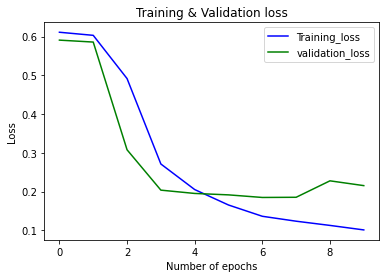

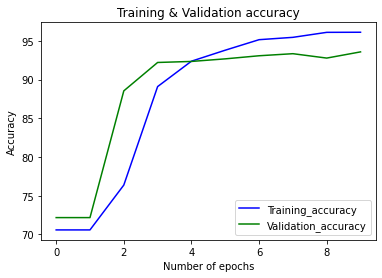

In [ ]:
plt.plot(range(10), training_loss, 'b-', label='Training_loss')
plt.plot(range(10), validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(range(10), training_accuracy, 'b-', label='Training_accuracy')
plt.plot(range(10), validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# model.eval()
correct_test_t = 0
total_test_t = 0
for test_batch_x, test_batch_y in test_loader:
        
    data,target = test_batch_x.to(device), test_batch_y.to(device)
        
    output = model(data)
     
    predicted = torch.max(output.data, 1)[1]
        
    total_test_t += len(target)
        
    correct_test_t += (predicted == target).float().sum()
        
test_accuracy = 100 * correct_test_t / float(total_test_t)

print('test_accuracy: {:.6f}%'.format(test_accuracy))

test_Loss: 0.001515921438112855 test_accuracy: 93.685654%
